## Code to analyze the popular Blackjack sidebet game, the Lucky Ladies. The Lucky Ladies pay out according to the pay table below
1. Queen of hearts pair and dealer has bj (1000 to 1)
2. Queen of hearts pair (200 to 1)
3. Matched 20 (25 to 1)
4. Suited 20 (10 to 1)
5. Unsuited 20 (4 to 1)

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from blackjack_sidebet_sim import Blackjack_shoe
import os
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, ensemble
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import comb
import operator

In [2]:
def analytical_lucky_ladies(num_decks_list,ev_list,num_games):
    matrix = []
    for num_decks in num_decks_list: 
        for running_count in range(4*5*num_decks): 
            q_hearts_with_bj = comb(num_decks,2)*comb(num_decks*4,1)*comb(num_decks*16-2,1)  
            q_hearts_no_bj = comb(num_decks,2)*comb(52*num_decks-2-running_count,2) - q_hearts_with_bj
            matched_20 = comb(15,1) * comb(num_decks,2) * comb(num_decks*52-2-running_count,2)
            suited_20 = 7*comb(4,1)*comb(num_decks,1)*comb(num_decks,1)*comb(num_decks*52-2,2)
            unsuited_20 = 18*comb(4,2)*comb(num_decks,1)*comb(num_decks,1)*comb(num_decks*52-2-running_count,2)
            total = comb(52*num_decks-running_count,4)*comb(4,2)
            other = total - (q_hearts_with_bj + q_hearts_no_bj + matched_20 + suited_20 + unsuited_20)
            sol = [q_hearts_with_bj,q_hearts_no_bj,matched_20,suited_20,unsuited_20,other]
            norm_sol = np.divide(sol, total)
            ev = sum(list(map(operator.mul, norm_sol, ev_list))) * num_games
            data = [num_decks,running_count,ev]
            matrix.append(data)
    return matrix

In [3]:
cards = ['ace','king','queen','jack','ten','nine','eight','seven','six','five','four','three','two']
suits = ['spades','hearts','clubs','diamonds']

In [4]:
card_values = {'ace':11,'king':10,'queen':10,'jack':10,'ten':10,'nine':9,'eight':8,\
           'seven':7,'six':6,'five':5,'four':4,'three':3,'two':2}

In [5]:
counting_df = pd.read_csv(os.getcwd()+'/counting_systems/high_low_blackjack.csv').drop(['Unnamed: 0'],axis=1)
counting_df.head()

,Card,Value
0,ace_of_spades,-1
1,ace_of_hearts,-1
2,ace_of_clubs,-1
3,ace_of_diamonds,-1
4,king_of_spades,-1


In [6]:
counting_rules = dict(zip(counting_df.Card, counting_df.Value))
small_cards = counting_df[counting_df['Value']>0].Card.tolist()

In [7]:
ev_list = [1000.,200.,25.,10.,4.,-1.]
num_decks_list = [8,7,6,5,4,3,2,1]
matrix = []
num_games = 100000
cost_to_play = 1 #1 unit (min bet is $1, max is $25 at most casinos)
avg_rt = num_games*30/3600 #assume 60 seconds/hand in real life. 
matrix = analytical_lucky_ladies(num_decks_list,ev_list,num_games)

In [8]:
df = pd.DataFrame(matrix,columns = ['num_decks_initial','running_count','expected_value'])
df = df[df['num_decks_initial']!=1]
df['avg (units/hour)'] =  df['expected_value']/avg_rt
df['true_count'] = df['running_count'] / ((df['num_decks_initial']*52 - df['running_count'])/52)
df.head()

,num_decks_initial,running_count,expected_value,avg (units/hour),true_count
0,8,0,-16732.567137,-20.079081,0.000000
1,8,1,-16212.949472,-19.455539,0.125301
2,8,2,-15688.412393,-18.826095,0.251208
3,8,3,-15158.894144,-18.190673,0.377724
4,8,4,-14624.332007,-17.549198,0.504854


## This analysis is perfect if we are constantly playing the game at these conditions. We must multiply the expected value by the frequency with which these conditions occur. This will give a more accurate representation of an hourly rate. 

In [9]:
num_decks=8
running_count = 0
freq_list = []
num_games = 10000
time_to_finish_all_shoes = 20*num_games / 60 # (in hours)
for i in range(0,num_games):
    shoe = Blackjack_shoe(num_decks_remaining=num_decks,running_count=running_count,\
                counting_rules=counting_rules,small_cards=small_cards,win_counter=0)  
    shoe.create_shoe()
    freq_list = freq_list + shoe.simulate_blackjack_shoe(0.95)

In [10]:
#Simulate game num_games times and aggregate true count situations. 
freq_df = pd.DataFrame(freq_list,columns = ['num_decks_initial','running_count','true_count'])
#freq_df['true_count'] = freq_df['running_count'] / freq_df['num_decks_initial']
freq_df.head()

,num_decks_initial,running_count,true_count
0,8.000000,0,0.000000
1,7.807692,3,0.384236
2,7.615385,8,1.050505
3,7.423077,10,1.347150
4,7.230769,9,1.244681


In [11]:
#Use value_counts to compute frequency with which these situations occur. 
freq_df = pd.DataFrame(freq_df.true_count.value_counts()).reset_index()
freq_df.columns = ['true_count','frequency']
freq_df.head()

,true_count,frequency
0,0.00,34086
1,3.25,1738
2,-3.25,1717
3,6.50,1587
4,-6.50,1561


In [12]:
#Convert to fraction of hour. 
freq_df['Fraction_of_hour'] = freq_df['frequency'] /freq_df['frequency'].sum()
freq_df.head()

,true_count,frequency,Fraction_of_hour
0,0.00,34086,0.083137
1,3.25,1738,0.004239
2,-3.25,1717,0.004188
3,6.50,1587,0.003871
4,-6.50,1561,0.003807


In [13]:
df.head()

,num_decks_initial,running_count,expected_value,avg (units/hour),true_count
0,8,0,-16732.567137,-20.079081,0.000000
1,8,1,-16212.949472,-19.455539,0.125301
2,8,2,-15688.412393,-18.826095,0.251208
3,8,3,-15158.894144,-18.190673,0.377724
4,8,4,-14624.332007,-17.549198,0.504854


In [14]:
X = df[['true_count']]
y = df[['avg (units/hour)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test).tolist()

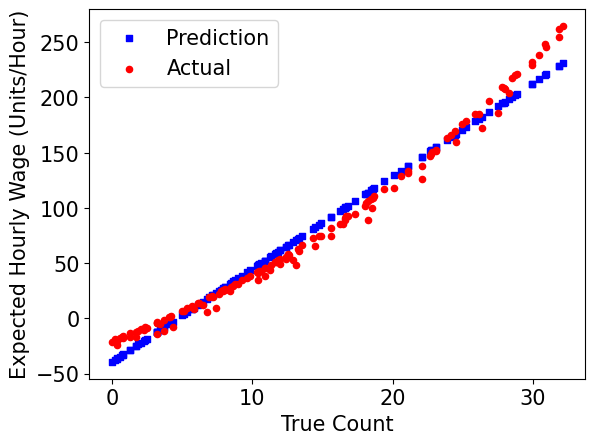

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_test.true_count, y_pred, s=20, c='b', marker="s", label='Prediction')
ax1.scatter(X_test.true_count,y_test, s=20, c='r', marker="o", label='Actual')
ax1.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.ylabel('Expected Hourly Wage (Units/Hour)',fontsize=15)
plt.xlabel('True Count',fontsize=15)
plt.show()

In [17]:
#Compute the expected hourly value, weighted by positive shoes. 
true_count_list = freq_df.true_count.tolist()
true_count_list = np.array(true_count_list).reshape(-1, 1)
model_results = reg.predict(true_count_list).tolist()
res = pd.DataFrame({'true_count':freq_df.true_count.tolist(),'Predicted_hourly_unit_rate':[item for sublist in model_results for item in sublist]})
res = res.merge(freq_df,left_on='true_count',right_on='true_count',how='inner')
res.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,true_count,Predicted_hourly_unit_rate,frequency,Fraction_of_hour
0,0.00,-39.442231,34086,0.083137
1,3.25,-12.103249,1738,0.004239
2,-3.25,-66.781212,1717,0.004188
3,6.50,15.235733,1587,0.003871
4,-6.50,-94.120194,1561,0.003807


In [18]:
res = res[res['Predicted_hourly_unit_rate']>0]
val = np.sum(np.multiply(res.Predicted_hourly_unit_rate,res.Fraction_of_hour))
val

1.928416810500754